# Predicting House Sale Prices
From Dataquest.io Guided Project.
This workflow will tie together the basics of machine learning, including feature transformation, selection, training/testing (model fit/predict).

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns
%matplotlib inline

ames = pd.read_csv('AmesHousing.tsv',sep='\t')

## Initial Functions

In [2]:
def transform_features(df):
  return df

def select_features(df):
  return df[['Gr Liv Area','SalePrice']]

def train_and_test(data):
  train = data[:1460]
  test = data[1460:]
  features = data.select_dtypes('number').columns.drop('SalePrice')
  lr = LinearRegression()
  lr.fit(train[features],train['SalePrice'])
  test_predictions = lr.predict(test[features])
  test_mse = mean_squared_error(test['SalePrice'],test_predictions)
  return test_mse ** (1/2)

transformed_df = transform_features(ames)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df)

print(rmse)

57088.25161263909


## First Updates to Functions

In [3]:
def transform_features(df):
  """
  Transform df and features into cleaner versions.
  """
  # drop all columns with 25% or higher null values
  trans_df = df.loc[:, df.isnull().mean() < .25]

  # for numerical columns with < 5% missing values, fill nulls with mode of column
  trans_df = trans_df.apply(lambda x: x.fillna(x.mode()) if (x.isnull().mean() < 0.05) & (np.issubdtype(x.dtype,np.number) == True) else x)
  
  # drop non-numerical columns with any missing values
  text_mv_counts = trans_df.select_dtypes(include=['object']).isnull().sum()

  # Filter Series to columns containing *any* missing values
  drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

  trans_df = trans_df.drop(columns=drop_missing_cols_2.index)

  # create new useful features
  trans_df['years_since_remod'] = trans_df['Yr Sold'] - trans_df['Year Remod/Add']
  trans_df['years_until_sale'] = trans_df['Yr Sold'] - trans_df['Year Built']

  # drop rows from the new columns with negative values
  trans_df.drop(index = trans_df[trans_df['years_since_remod'] < 0].index,inplace=True)
  trans_df.drop(index = trans_df[trans_df['years_until_sale'] < 0].index,inplace=True)

  # drop columns that are a) not useful: PID, Order and b) leak data about the final sale
  trans_df = trans_df.drop(columns=["PID", "Order", "Mo Sold", "Yr Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"])
  return trans_df

def select_features(df):
  return df[['Gr Liv Area','SalePrice']]

def train_and_test(data):
  train = data[:1460]
  test = data[1460:]
  features = data.select_dtypes('number').columns.drop('SalePrice')
  lr = LinearRegression()
  lr.fit(train[features],train['SalePrice'])
  test_predictions = lr.predict(test[features])
  test_mse = mean_squared_error(test['SalePrice'],test_predictions)
  return test_mse ** (1/2)

transformed_df = transform_features(ames)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df)

print(rmse)

55275.367312413066


## Feature Selection
Time to explore correlation of numerical columns with SalePrice (target column) and consider which columns should be converted to categorical variables.

In [5]:
sorted_corrs = transformed_df.select_dtypes(np.number).corr()['SalePrice'].apply(abs).sort_values()
strong_corrs = sorted_corrs[sorted_corrs > .4]
print(strong_corrs)

BsmtFin SF 1         0.439051
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.513121
Garage Yr Blt        0.527047
years_since_remod    0.534985
Full Bath            0.546118
years_until_sale     0.558979
1st Flr SF           0.635185
Garage Area          0.641690
Total Bsmt SF        0.643782
Garage Cars          0.648427
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64


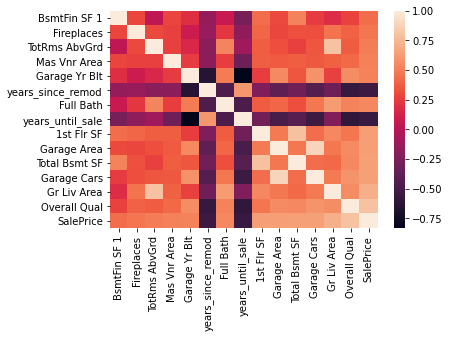

In [6]:
corrmat = transformed_df[strong_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

In [7]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
transform_cat_cols = []
for col in nominal_features:
  if col in transformed_df.columns:
    transform_cat_cols.append(col)
uniqueness_counts = transformed_df[transform_cat_cols].apply(lambda col: len(col.unique())).sort_values()
print(uniqueness_counts)

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64


In [8]:
# drop columns with more than 10 unique values
transformed_df = transformed_df.drop(columns=uniqueness_counts[uniqueness_counts > 10].index)

In [9]:
## Select just the remaining text columns and convert to categorical
text_cols = transformed_df.select_dtypes(include=['object'])
for col in text_cols:
    transformed_df[col] = transformed_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe
transformed_df = pd.concat([
    transformed_df, 
    pd.get_dummies(transformed_df.select_dtypes(include=['category']))
], axis=1).drop(columns=text_cols)

In [22]:
# tie feature selection changes back into functions
def transform_features(df):
  """
  Transform df and features into cleaner versions.
  """
  # drop all columns with 5% or higher null values
  trans_df = df.loc[:, df.isnull().mean() < .05].copy()

  # for numerical columns, fill nulls with mean of column
  num_cols = trans_df.select_dtypes(np.number).columns
  trans_df[num_cols] = trans_df[num_cols].fillna(trans_df[num_cols].mean())
  # trans_df = trans_df.apply(lambda x: x.fillna(x.mode()) if np.issubdtype(x.dtype,np.number) == True else x)
  
  # drop non-numerical columns with any missing values
  text_mv_counts = trans_df.select_dtypes(include=['object']).isnull().sum()

  # Filter Series to columns containing *any* missing values
  drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

  trans_df = trans_df.drop(columns=drop_missing_cols_2.index)

  # create new useful features
  trans_df['years_since_remod'] = trans_df['Yr Sold'] - trans_df['Year Remod/Add']
  trans_df['years_until_sale'] = trans_df['Yr Sold'] - trans_df['Year Built']

  # drop rows from the new columns with negative values
  trans_df.drop(index = trans_df[trans_df['years_since_remod'] < 0].index,inplace=True)
  trans_df.drop(index = trans_df[trans_df['years_until_sale'] < 0].index,inplace=True)

  # drop columns that are a) not useful: PID, Order and b) leak data about the final sale
  trans_df = trans_df.drop(columns=["PID", "Order", "Mo Sold", "Yr Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"])
  return trans_df

def select_features(df):
  sorted_corrs = df.select_dtypes(np.number).corr()['SalePrice'].apply(abs).sort_values()
  df = df.drop(columns = sorted_corrs[sorted_corrs < 0.4].index)

  nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
  transform_cat_cols = []
  for col in nominal_features:
    if col in df.columns:
      transform_cat_cols.append(col)
  uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.unique())).sort_values()
  df = df.drop(columns=uniqueness_counts[uniqueness_counts > 10].index)

  ## Select just the remaining text columns and convert to categorical
  text_cols = df.select_dtypes(include=['object'])
  for col in text_cols:
    df[col] = df[col].astype('category')
    
  # Create dummy columns and add back to the dataframe
  df = pd.concat([
    df, 
    pd.get_dummies(df.select_dtypes(include=['category']))
    ], axis=1).drop(columns=text_cols)
  return df

def train_and_test(data, k=0):
  """
  Tests and fits a linear regression model based on defined k cross-validation.
  Default k=0 results in simple holdout validation.
  """
  features = data.select_dtypes('number').columns.drop('SalePrice')
  lr = LinearRegression()
  if k == 0:
    train = data[:1460]
    test = data[1460:]
    lr.fit(train[features],train['SalePrice'])
    test_predictions = lr.predict(test[features])
    test_mse = mean_squared_error(test['SalePrice'],test_predictions)
    return test_mse ** (1/2)
  elif k == 1:
    shuffled_df = data.sample(frac=1, )
    train = shuffled_df[:1460]
    test = shuffled_df[1460:]
    lr.fit(train[features],train['SalePrice'])
    predictions_one = lr.predict(test[features])
    rmse_one = np.sqrt(mean_squared_error(test['SalePrice'],predictions_one))
    lr.fit(test[features],test['SalePrice'])
    predictions_two = lr.predict(train[features])
    rsme_two = np.sqrt(mean_squared_error(train['SalePrice'],predictions_two))
    return (rmse_one + rsme_two) / 2
  else:
    kf = KFold(n_splits=k,shuffle=True)
    rmses = cross_val_score(lr,data[features],data['SalePrice'],cv=kf,scoring='neg_root_mean_squared_error')
    return np.mean(np.absolute(rmses))
  

transformed_df = transform_features(ames)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df,4)

print(rmse)

28478.15910500009
